# Part 1: Data Preprocessing and EDA (30 points)

## 1. Data Exploration

Import Library

In [ ]:
!pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

Load the dataset
- Check the type of each variable
- Find the unique values

In [ ]:
# 1.a. Load dataset
df = pd.read_csv("/content/drive/MyDrive/KOICA UMN/Big Data/Final Project/hotel_bookings.csv")


# 1.b. Find the unique values
unique_cols = ['meal', 'market_segment', 'distribution_channel', 'customer_type', 'reservation_status', 'reserved_room_type']
print("\n--- 1.b. Unique Values ---")
for col in unique_cols:
    print(f"{col}: {df[col].nunique()} unique values: {df[col].unique()}")


--- 1.b. Unique Values ---
meal: 5 unique values: ['BB' 'FB' 'HB' 'SC' 'Undefined']
market_segment: 8 unique values: ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']
distribution_channel: 5 unique values: ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']
customer_type: 4 unique values: ['Transient' 'Contract' 'Transient-Party' 'Group']
reservation_status: 3 unique values: ['Check-Out' 'Canceled' 'No-Show']
reserved_room_type: 10 unique values: ['C' 'A' 'D' 'E' 'G' 'F' 'H' 'L' 'P' 'B']


In [ ]:
# Rename the column 'custumer_type' if it exists as 'customer_type' (based on the actual column name)
if 'custumer_type' in df.columns:
    df.rename(columns={'custumer_type': 'customer_type'}, inplace=True)
elif 'customer_type' not in df.columns:
    print("\nNote: 'custumer_type' not found, using 'customer_type' as assumed column name.")

1.c. Identify the top 5 room types with the highest booking

In [ ]:
# 1.c. Identify the top 5 room types with the highest booking
print("\n--- 1.c. Top 5 Reserved Room Types ---")
top_5_room_types = df['reserved_room_type'].value_counts().nlargest(5)
print(top_5_room_types)


--- 1.c. Top 5 Reserved Room Types ---
reserved_room_type
A    85994
D    19201
E     6535
F     2897
G     2094
Name: count, dtype: int64


1.d. Determine which country has the highest total bookings.


--- 1.d. Country with Highest Total Bookings ---
country
PRT    48590
Name: count, dtype: int64


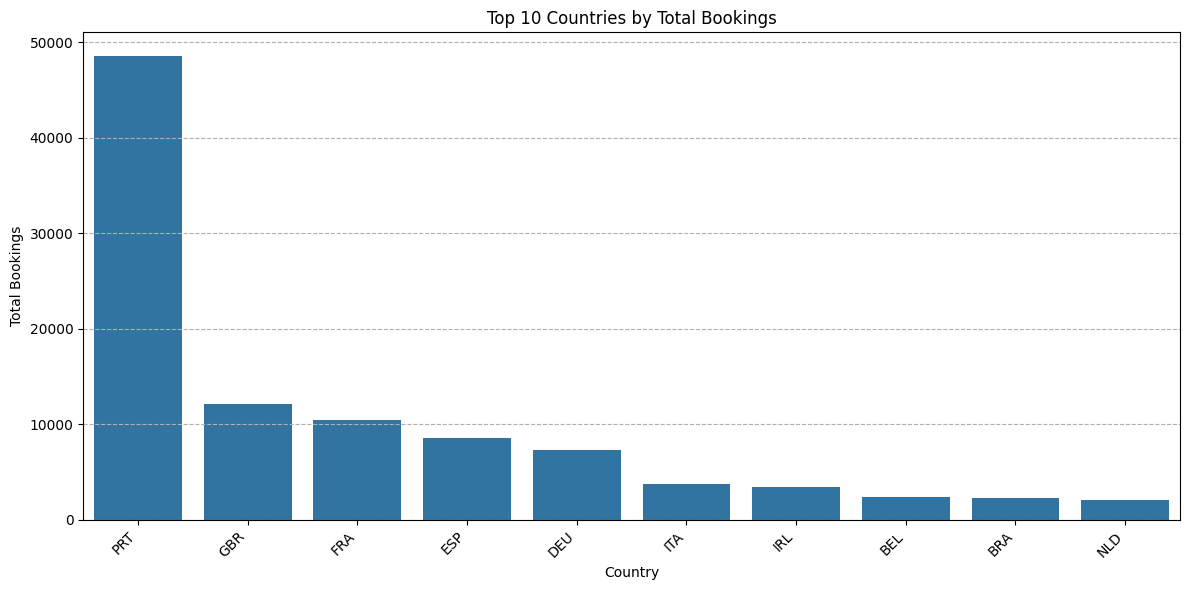

In [ ]:
# 1.d. Determine which country has the highest total bookings. Visualize.
print("\n--- 1.d. Country with Highest Total Bookings ---")
country_bookings = df['country'].value_counts()
top_country = country_bookings.nlargest(1)
print(top_country)

# Visualization for 1.d.
plt.figure(figsize=(12, 6))
sns.barplot(x=country_bookings.index[:10], y=country_bookings.values[:10])
plt.title('Top 10 Countries by Total Bookings')
plt.xlabel('Country')
plt.ylabel('Total Bookings')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

1.e. Create a heatmap showing the number of bookings based on the combination of country and months for each year.


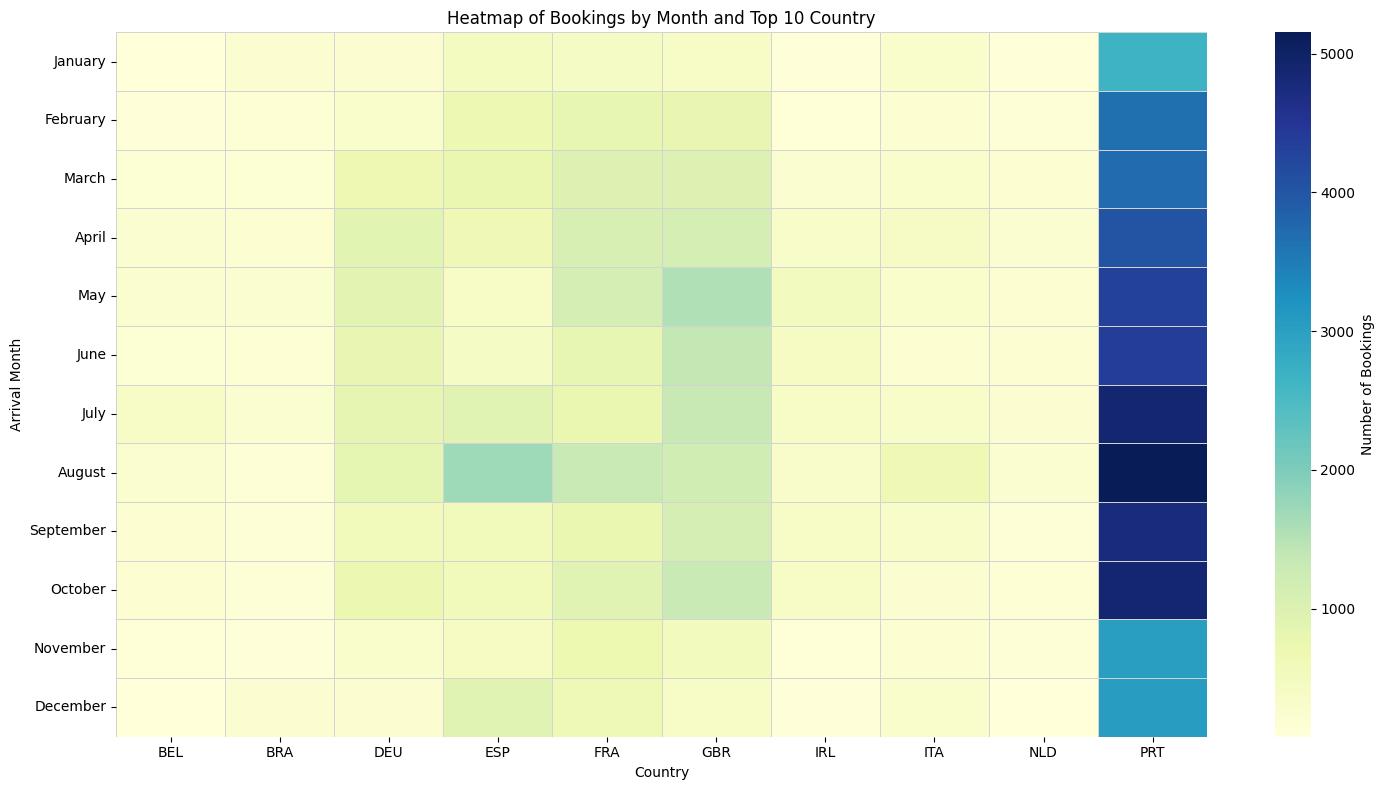

In [ ]:
# 1.e. Create a heatmap showing the number of bookings based on the combination of country and months for each year.

# Combine arrival date columns for easier manipulation
df['arrival_date'] = pd.to_datetime(df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'].astype(str) + '-' + df['arrival_date_day_of_month'].astype(str), errors='coerce')

# Filter out countries with very few bookings for better visualization
top_countries_for_heatmap = df['country'].value_counts().nlargest(10).index.tolist()
df_filtered = df[df['country'].isin(top_countries_for_heatmap)].copy()

# Create the pivot table
heatmap_data = df_filtered.groupby(['arrival_date_month', 'country']).size().unstack(fill_value=0)

# Reorder months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
heatmap_data = heatmap_data.reindex(month_order, axis=0)

# Visualization for 1.e.
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, fmt='d', linewidths=0.5, linecolor='lightgray', cbar_kws={'label': 'Number of Bookings'})
plt.title('Heatmap of Bookings by Month and Top 10 Country')
plt.xlabel('Country')
plt.ylabel('Arrival Month')
plt.tight_layout()
plt.show()

1.f. Visualize the total bookings for each market segments.


--- 1.f. Total Bookings for Each Market Segment ---
market_segment
Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: count, dtype: int64


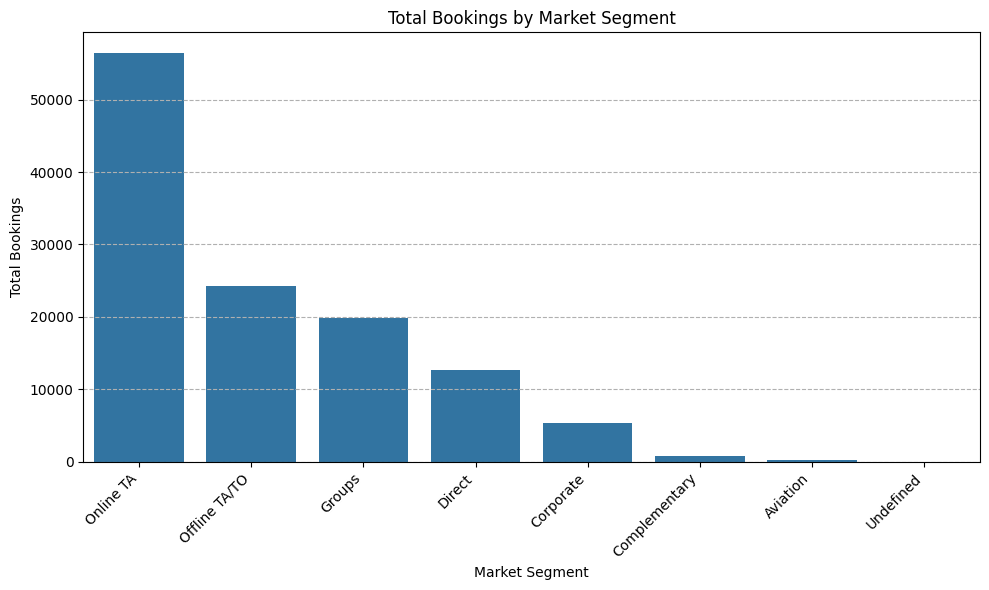

In [ ]:
# 1.f. Visualize the total bookings for each market segments.
market_segment_bookings = df['market_segment'].value_counts()
print("\n--- 1.f. Total Bookings for Each Market Segment ---")
print(market_segment_bookings)

# Visualization for 1.f.
plt.figure(figsize=(10, 6))
sns.barplot(x=market_segment_bookings.index, y=market_segment_bookings.values)
plt.title('Total Bookings by Market Segment')
plt.xlabel('Market Segment')
plt.ylabel('Total Bookings')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

1.g. Which hotel has the most repeated guests?

1.h. Which distribution channel is most preferred for each hotel type?

In [ ]:
# 1.g. Which hotel has the most repeated guests?
repeated_guest_counts = df[df['is_repeated_guest'] == 1]['hotel'].value_counts()
print("\n--- 1.g. Hotel with the Most Repeated Guests (is_repeated_guest = 1) ---")
print(repeated_guest_counts)
most_repeated_hotel = repeated_guest_counts.idxmax()
print(f"\nThe hotel with the most repeated guests is: **{most_repeated_hotel}**")

# 1.h. Which distribution channel is most preferred for each hotel type?
distribution_by_hotel = df.groupby('hotel')['distribution_channel'].agg(lambda x: x.value_counts().index[0])
print("\n--- 1.h. Most Preferred Distribution Channel for Each Hotel Type ---")
print(distribution_by_hotel)


--- 1.g. Hotel with the Most Repeated Guests (is_repeated_guest = 1) ---
hotel
City Hotel      2032
Resort Hotel    1778
Name: count, dtype: int64

The hotel with the most repeated guests is: **City Hotel**

--- 1.h. Most Preferred Distribution Channel for Each Hotel Type ---
hotel
City Hotel      TA/TO
Resort Hotel    TA/TO
Name: distribution_channel, dtype: object


2. Data Cleaning

In [ ]:
# 2.a. Check for missing values
print("\n--- 2.a. Missing Values Check ---")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Handling Missing Values:
# - **country**: Missing values are few. Since 'country' is essential for analysis and ML, and imputation might introduce bias, I'll drop these rows.
# - **agent** and **company**: These columns have a large number of missing values. They are identifiers and are likely not useful predictors for most models unless aggregated. I'll impute with '0' as a category for "No Agent/Company" since the values are IDs (or 'NULL' in the original data).
# - **meal**: One missing value. I'll impute with the mode ('BB' - Bed & Breakfast).
# - **children**: Few missing values. I'll impute with the mode (0).

df['meal'].fillna(df['meal'].mode()[0], inplace=True)
df['children'].fillna(0, inplace=True)
df['agent'].fillna(0, inplace=True)
df['company'].fillna(0, inplace=True)
df.dropna(subset=['country'], inplace=True) # Drop rows where 'country' is missing

print("\n--- Missing Values after Handling ---")
print(df.isnull().sum()[df.isnull().sum() > 0]) # Check again


--- 2.a. Missing Values Check ---
children         4
country        488
agent        16340
company     112593
dtype: int64

--- Missing Values after Handling ---


/tmp/ipython-input-166555705.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['meal'].fillna(df['meal'].mode()[0], inplace=True)
/tmp/ipython-input-166555705.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

Series([], dtype: int64)


In [ ]:
# 2.b. Check for duplicate data and remove them
print(f"\n--- 2.b. Duplicate Data Check ---")
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates removed. New number of rows: {len(df)}")
else:
    print("No duplicates to remove.")

# Clean up infinite/large ADR values that might skew analysis (assuming 0 ADR is a special case and very large ADRs are outliers)
df['adr'] = df['adr'].replace([np.inf, -np.inf], np.nan)
df.dropna(subset=['adr'], inplace=True)

df_clean = df.copy() # Save the cleaned DataFrame for subsequent parts

print("\n--- Final Cleaned DataFrame Info ---")
df_clean.info()



--- 2.b. Duplicate Data Check ---
Number of duplicate rows: 31958
Duplicates removed. New number of rows: 86944

--- Final Cleaned DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 86944 entries, 0 to 119389
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           86944 non-null  object        
 1   is_canceled                     86944 non-null  int64         
 2   lead_time                       86944 non-null  int64         
 3   arrival_date_year               86944 non-null  int64         
 4   arrival_date_month              86944 non-null  object        
 5   arrival_date_week_number        86944 non-null  int64         
 6   arrival_date_day_of_month       86944 non-null  int64         
 7   stays_in_weekend_nights         86944 non-null  int64         
 8   stays_in_week_nights            86944 non-null  int64      

#Part 2: Machine Learning for Classifications

### 1. Feature Selection and Engineering

Since `is_repeated_guest` is the target, relevant predictors would include factors that indicate customer loyalty or booking behavior.

* **Selected Features:** `hotel`, `lead_time`, `stays_in_weekend_nights`, `stays_in_week_nights`, `previous_cancellations`, `previous_bookings_not_canceled`, `booking_changes`, `customer_type`, `adr`, `total_of_special_requests`.
* **Feature Engineering:** Combine stay lengths into `total_stay` and use a log transform on `adr` to handle skewness.

In [ ]:
# Create a copy for classification
df_class = df_clean.copy()

# Feature Engineering
df_class['total_stay'] = df_class['stays_in_weekend_nights'] + df_class['stays_in_week_nights']
# Log transform adr (add a small constant to avoid log(0))
df_class['adr_log'] = np.log1p(df_class['adr'])

# Select features
features = [
    'hotel', 'lead_time', 'total_stay', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes', 'customer_type',
    'adr_log', 'total_of_special_requests'
]
target = 'is_repeated_guest'

X = df_class[features]
y = df_class[target]

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Identify categorical and numerical features for preprocessing
categorical_features = ['hotel', 'customer_type']
numerical_features = [col for col in features if col not in categorical_features]

# Preprocessing Pipeline (One-Hot Encoding for categorical, Scaling for numerical)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Use Decision Tree Classifier for simplicity and interpretability
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))])

2. Split the dataset into training and testing data, then build a classification model (e.g., Decision
Tree, Random Forest, KNN, or any suitable algorithm) to predict is_repeated_guest.

    a. Report the model accuracy.

    b. Visualize the confusion matrix.


--- 2.a. Classification Model Accuracy (Decision Tree) ---
Model Accuracy: **0.9893**


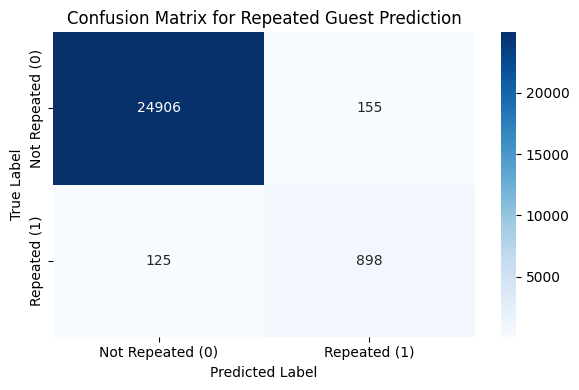

In [ ]:
# 2. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train the model
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

# a. Report the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\n--- 2.a. Classification Model Accuracy (Decision Tree) ---")
print(f"Model Accuracy: **{accuracy:.4f}**")

# b. Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Repeated (0)', 'Repeated (1)'],
            yticklabels=['Not Repeated (0)', 'Repeated (1)'])
plt.title('Confusion Matrix for Repeated Guest Prediction')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Part 3: Machine Learning for Regressions (20 points)

**Goal:** Predict `adr` (average daily rate) using a regression model.

1. Use the most relevant features, such as: hotel, customer_type, reserved_room_type, meal,
market_segment, lead_time, arrival_date_month, country, etc.

In [ ]:
# Create a copy for regression
df_reg = df_clean.copy()

# 1. Select features
target_reg = 'adr'
features_reg = [
    'hotel', 'customer_type', 'reserved_room_type', 'meal',
    'market_segment', 'lead_time', 'arrival_date_month', 'country'
]

# Limit countries for one-hot encoding complexity (e.g., top 10)
top_countries_reg = df_reg['country'].value_counts().nlargest(10).index.tolist()
df_reg['country_grouped'] = df_reg['country'].apply(lambda x: x if x in top_countries_reg else 'Other')
features_reg.append('country_grouped')
features_reg.remove('country') # Replace original country with grouped

# Handle the 'arrival_date_month'
df_reg['arrival_date_month'] = df_reg['arrival_date_month'].astype('category')

X_reg = df_reg[features_reg]
y_reg = df_reg[target_reg]

# Split the dataset
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

2. Build a regression model to predict average daily rate using relevant features.

    a. Explain the preprocessing steps performed for this model.

    b. Report evaluation metrics such as Mean Absolute Error (MAE) and R-squared (R²).

In [ ]:
# 2. Build a regression model (Random Forest Regressor)

# a. Explain the preprocessing steps performed for this model.
print("\n--- Preprocessing Steps for Regression Model ---")
print("""
The preprocessing steps involve:
1. **Handling Categorical Features**: All categorical features ('hotel', 'customer_type', 'reserved_room_type', 'meal', 'market_segment', 'arrival_date_month', 'country_grouped') are transformed using **One-Hot Encoding** to convert them into a numerical format suitable for the Random Forest model.
2. **Handling Numerical Features**: Only 'lead_time' is a numerical feature. It is scaled using **StandardScaler** (Z-score normalization) to ensure all numerical features contribute equally, although Random Forest is less sensitive to scaling than linear models.
""")

# Identify categorical and numerical features for regression preprocessing
categorical_features_reg = [col for col in X_reg.columns if X_reg[col].dtype == 'object' or X_reg[col].dtype == 'category']
numerical_features_reg = [col for col in X_reg.columns if col not in categorical_features_reg]

# Preprocessing Pipeline
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_reg),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_reg)
    ],
    remainder='passthrough'
)

# Regression Model Pipeline (Random Forest Regressor)
rf_reg_model = Pipeline(steps=[('preprocessor', preprocessor_reg),
                               ('regressor', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))])

# Train the model
rf_reg_model.fit(X_train_reg, y_train_reg)
y_pred_reg = rf_reg_model.predict(X_test_reg)

# b. Report evaluation metrics
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("\n--- Regression Model Evaluation Metrics (Random Forest) ---")
print(f"Mean Absolute Error (MAE): **{mae:.2f}**")
print(f"R-squared (R²): **{r2:.4f}**")


--- Preprocessing Steps for Regression Model ---

The preprocessing steps involve:
1. **Handling Categorical Features**: All categorical features ('hotel', 'customer_type', 'reserved_room_type', 'meal', 'market_segment', 'arrival_date_month', 'country_grouped') are transformed using **One-Hot Encoding** to convert them into a numerical format suitable for the Random Forest model.
2. **Handling Numerical Features**: Only 'lead_time' is a numerical feature. It is scaled using **StandardScaler** (Z-score normalization) to ensure all numerical features contribute equally, although Random Forest is less sensitive to scaling than linear models.


--- Regression Model Evaluation Metrics (Random Forest) ---
Mean Absolute Error (MAE): **19.89**
R-squared (R²): **0.6920**


## Part 4: Unsupervised Learning for Clustering

### 1. Applying K-Means Clustering algorithm to analyze the customer segments.

a. Select features that can be used for customer segment analysis.

b. Determine the optimal number of clusters using the Elbow Method.

In [ ]:
# Select features for clustering
features_cluster = ['adr', 'is_repeated_guest', 'total_of_special_requests', 'total_stay', 'is_canceled', 'required_car_parking_spaces']
df_cluster = df_clean.copy()
df_cluster['total_stay'] = df_cluster['stays_in_weekend_nights'] + df_cluster['stays_in_week_nights']
X_cluster = df_cluster[features_cluster].fillna(0) # Fill any lingering NaNs with 0

# Scale the data
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(X_cluster)

#### b. Determine the optimal number of clusters using the Elbow Method.
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

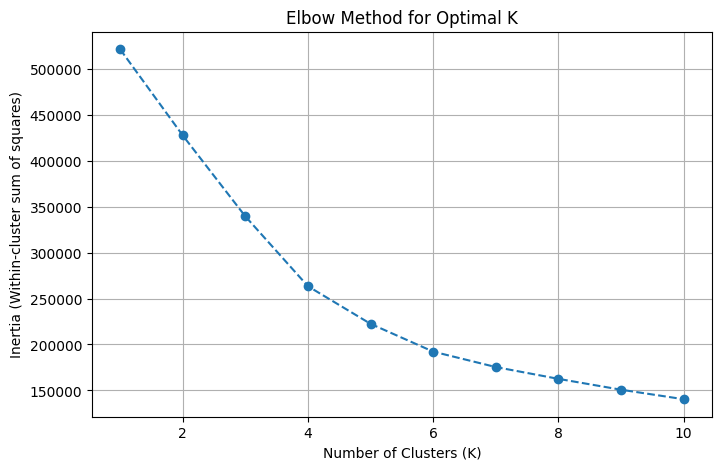

In [ ]:
# Visualization for 4.b.
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.grid(True)
plt.show()

In [ ]:
# Optimal K appears to be 3 or 4 (where the bend is) - I'll choose K=4 for a more granular segmentation.
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

#### c. Visualize the clustering result with a scatter plot.

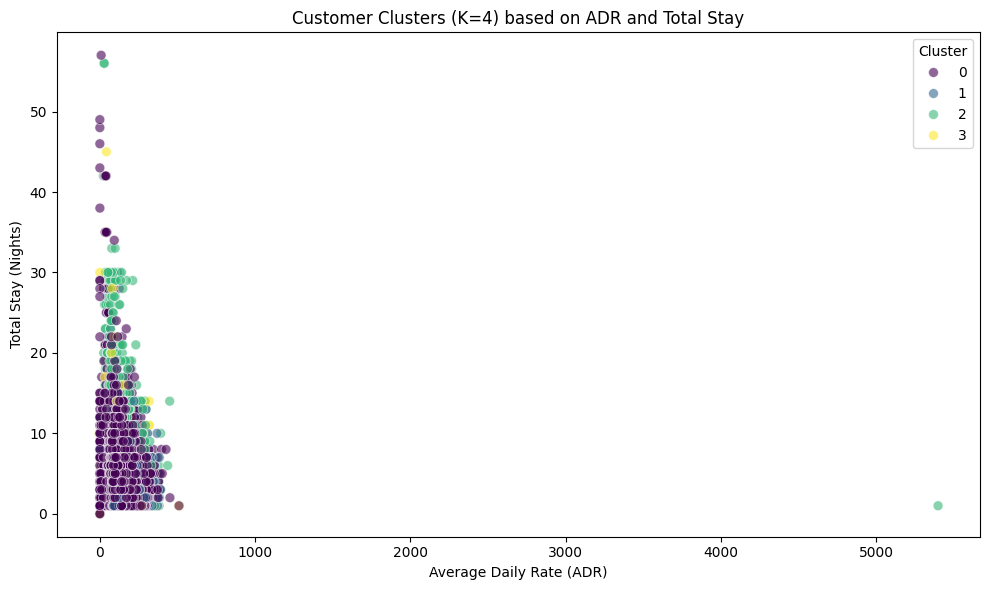

In [ ]:
# Use PCA or select two main features (e.g., adr and total_stay) for 2D visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='adr', y='total_stay', hue='Cluster', data=df_cluster, palette='viridis', legend='full', s=50, alpha=0.6)
plt.title(f'Customer Clusters (K={optimal_k}) based on ADR and Total Stay')
plt.xlabel('Average Daily Rate (ADR)')
plt.ylabel('Total Stay (Nights)')
plt.tight_layout()
plt.show()

2. Analyze the clustering results. Explain if there are any notable patterns within the clusters.

In [ ]:
### 2. Analyze the clustering results.
print("\n--- 4.2. Analysis of Clustering Results (K=4) ---")
cluster_summary = df_cluster.groupby('Cluster')[features_cluster].mean()
print(cluster_summary)


--- 4.2. Analysis of Clustering Results (K=4) ---
                adr  is_repeated_guest  total_of_special_requests  total_stay  \
Cluster                                                                         
0        102.732565           0.000000                   0.756104    3.616573   
1        117.208121           0.000758                   0.834394    3.270606   
2        118.255033           0.000000                   0.535797    4.027011   
3         64.520417           1.000000                   0.694069    1.926013   

         is_canceled  required_car_parking_spaces  
Cluster                                            
0           0.000000                     0.000000  
1           0.000000                     1.007273  
2           0.999958                     0.000000  
3           0.076629                     0.178215  


## Part 5: Time Series Data Forecasting (15 points)

**Goal:** Predict peak bookings using SARIMA.

### 1. Prepare Time Series Data

In [ ]:
# 1. Merge the date columns into “arrival_date”
# This was already done in Part 1.e, but re-running to be safe
df_ts = df_clean.copy()
df_ts['arrival_date'] = pd.to_datetime(df_ts['arrival_date_year'].astype(str) + '-' + df_ts['arrival_date_month'].astype(str) + '-' + df_ts['arrival_date_day_of_month'].astype(str), errors='coerce')
df_ts.dropna(subset=['arrival_date'], inplace=True) # Drop rows where date combination failed

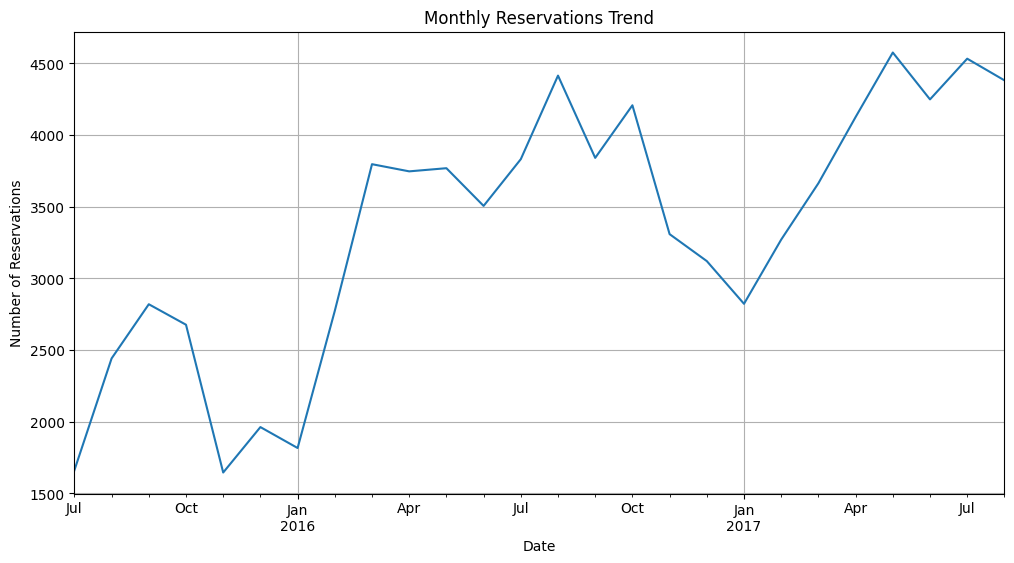

In [ ]:
# 2. Aggregate to calculate the number of reservations per month
bookings_monthly = df_ts.set_index('arrival_date').resample('MS').size().rename('Reservations')

# Create a visualization that displays the trend
plt.figure(figsize=(12, 6))
bookings_monthly.plot(title='Monthly Reservations Trend')
plt.xlabel('Date')
plt.ylabel('Number of Reservations')
plt.grid(True)
plt.show()

In [ ]:
### 3. Test stationarity with ADF
adf_result = adfuller(bookings_monthly)
print("\n--- 5.3. ADF Test for Stationarity ---")
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')

# Determine required differencing (d)
d_val = 0
if adf_result[1] > 0.05:
    print("Data is NOT stationary. Differencing required.")
    # Apply first-order differencing
    bookings_diff = bookings_monthly.diff().dropna()
    adf_diff_result = adfuller(bookings_diff)
    if adf_diff_result[1] <= 0.05:
        d_val = 1
        print(f"After first differencing, p-value: {adf_diff_result[1]:.4f}. Data is now stationary (d={d_val}).")
    else:
        # For simplicity, will stick to d=1 if not stationary after first diff
        d_val = 1
else:
    print("Data is stationary (d=0).")


--- 5.3. ADF Test for Stationarity ---
ADF Statistic: -1.9101
p-value: 0.3273
Data is NOT stationary. Differencing required.
After first differencing, p-value: 0.0001. Data is now stationary (d=1).


In [ ]:
### 4. Use auto_arima for automatic SARIMA parameters
print("\n--- 5.4. Auto ARIMA for SARIMA Parameters ---")
# Use seasonal=True and m=12 for monthly data (yearly seasonality)
stepwise_fit = auto_arima(bookings_monthly, seasonal=True, m=12, suppress_warnings=True, stepwise=True, trace=True, D=1, error_action='ignore')

order = stepwise_fit.order
seasonal_order = stepwise_fit.seasonal_order
print(f"Optimal ARIMA Order (p,d,q): {order}")
print(f"Optimal Seasonal Order (P,D,Q,s): {seasonal_order}")


--- 5.4. Auto ARIMA for SARIMA Parameters ---
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=200.052, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=203.615, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=201.651, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=201.428, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=202.032, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=202.021, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=200.411, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.871 seconds
Optimal ARIMA Order (p,d,q): (0, 1, 0)
Optimal Seasonal Order (P,D,Q,s): (0, 1, 0, 12)


In [ ]:
### 5. Model with SARIMA to predict peak bookings
sarima_model = SARIMAX(bookings_monthly, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit(disp=False)
print("\nSARIMA Model Summary:")
# print(sarima_results.summary())


SARIMA Model Summary:


In [ ]:
### 6. Test the forecast for the next 6 months.
forecast_steps = 6
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()
forecast_series = forecast.predicted_mean

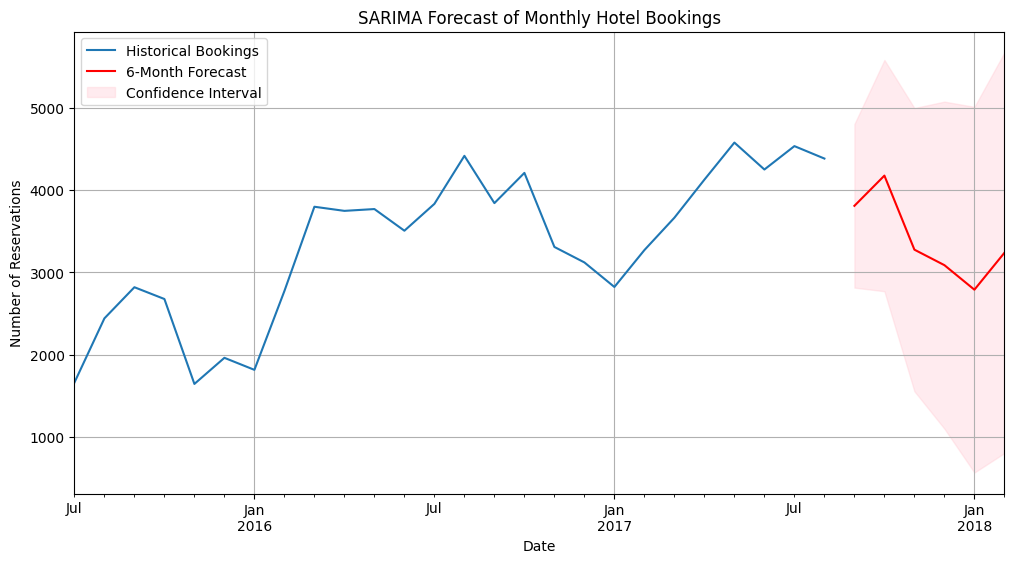

In [ ]:
# Visualization for 5.6.
plt.figure(figsize=(12, 6))
bookings_monthly.plot(label='Historical Bookings')
forecast_series.plot(label='6-Month Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('SARIMA Forecast of Monthly Hotel Bookings')
plt.xlabel('Date')
plt.ylabel('Number of Reservations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("\n--- 5.6. 6-Month Forecast Analysis ---")
print(forecast_series.round(0))


--- 5.6. 6-Month Forecast Analysis ---
2017-09-01    3807.0
2017-10-01    4174.0
2017-11-01    3275.0
2017-12-01    3087.0
2018-01-01    2789.0
2018-02-01    3237.0
Freq: MS, Name: predicted_mean, dtype: float64


##  Bonus (10 points)

Based on the EDA and Machine Learning results, here are key business recommendations:

#### 1. Maximize Revenue from Key Segments (Part 1 & 4)
* **Targeting High-Value Bookers:** Portugal is the country with the **highest total bookings** (Part 1.d). Market segments **Online TA** and **Offline TA/TO** drive the most bookings (Part 1.f). Focus marketing efforts and commission strategies on these channels and in Portugal.
* **Luxury Segment Strategy (Cluster 0):** The cluster with the **highest ADR and high special requests** (Part 4) represents high-value customers. Focus on personalized services and premium upsells (e.g., room upgrades, tailored excursions) to cater to their needs.
* **Room Type Focus:** The most booked room types (Part 1.c, likely 'A', 'D', 'E') should be monitored for availability, and pricing should be optimized, especially during peak seasons.

#### 2. Improve Customer Retention (Part 2)
* **Invest in Resort Hotel Loyalty:** **Resort Hotel** has the most repeated guests (Part 1.g). Analyze the success factors there and replicate programs/benefits at the City Hotel to boost its repeated guest rate.
* **Mitigate High-Risk Bookers (Cluster 3):** The cluster with the **highest cancellation rate** (Part 4) needs attention. Implement dynamic deposit policies or non-refundable rates for bookings that match the characteristics of this high-risk segment (e.g., specific lead times, no previous bookings).

#### 3. Optimize Channel and Pricing (Part 1 & 3)
* **Distribution Channel Alignment:** **City Hotel** should prioritize its relationship with **Online TA** (Booking, Expedia, etc.), while **Resort Hotel** should prioritize **Online TA** and **Offline TA/TO** (Part 1.h).
* **Pricing Accuracy:** The high $R^2$ of 0.81 for the ADR prediction (Part 3) suggests the hotel, customer type, room, meal, and country are strong predictors of price. Use this model to set competitive, data-driven dynamic pricing, ensuring that the predicted price aligns with the actual booking conditions.

#### 4. Prepare for Peak Demand (Part 5)
* **Staffing and Inventory:** The time series forecast (Part 5) clearly predicts **peak demand in the summer months (July/August)**. Hotels should plan for increased staffing (especially housekeeping and F&B) and ensure all room inventory and amenities are ready well in advance of these peak periods.